In [ ]:
import numpy as np
import sys, os 
sys.path.append('../Netket/')
sys.path.append('../ClusterExpansion/')
import netket as nk
import itertools
import matplotlib.pyplot as plt 
from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor

In [2]:
hypotheses = {
    "std_phase" : std_phase,
    "IPR" : ipr,
    "SPCA" : pca_entropy,
    "Renyi_2" : renyi_entropy,
    "uniform_state_overlap" : uniform_state_overlap,
    "mean_amplitude" : mean_amplitude,
}

data_root = '..'

h5_files_opt = [os.path.join(f"{data_root}/data/data_optimal_basis_rbm", f) for f in os.listdir(f'{data_root}/data/data_optimal_basis_rbm') if f.endswith('.h5')]
df_opt = analysis.load_outputs_to_dataframe(h5_files_opt, load_eigenstates=False)
df_opt = analysis.attach_hypotheses_fields(df_opt, hypotheses)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

230


In [20]:
features = list(hypotheses.keys())
traindf = df_opt[features + ['infidelity']].dropna()
traindf = traindf[traindf['infidelity'] <  0.6]
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['infidelity'], test_size=0.8, random_state=42)
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

Mean Squared Error: 0.022630621875034968
Percentage error in prediction: 744.860072831811


In [21]:
traindf.head()

,std_phase,IPR,SPCA,Renyi_2,uniform_state_overlap,mean_amplitude,infidelity
0,0.179447,0.000042,0.978425,10.079338,0.761920,0.003465,0.000958
1,0.548042,0.000019,0.997826,10.877749,0.703497,0.003803,0.010293
2,0.571434,0.000234,0.955055,8.359235,0.475908,0.003180,0.077553
3,1.630023,0.000041,0.990663,10.113691,0.000204,0.003188,0.501937
4,0.409339,0.000042,0.980519,10.073536,0.705761,0.003542,0.006239


In [25]:
features = list(hypotheses.keys())
traindf = df_opt[features + ['Delta_E']].dropna()
traindf = traindf[traindf['Delta_E'] <  0.6]
print(len(traindf))
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['Delta_E'], test_size=0.8, random_state=42)
model = RandomForestRegressor(n_estimators=10000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

230
Mean Squared Error: 0.0003652242580258962
Percentage error in prediction: 448.00885933756865


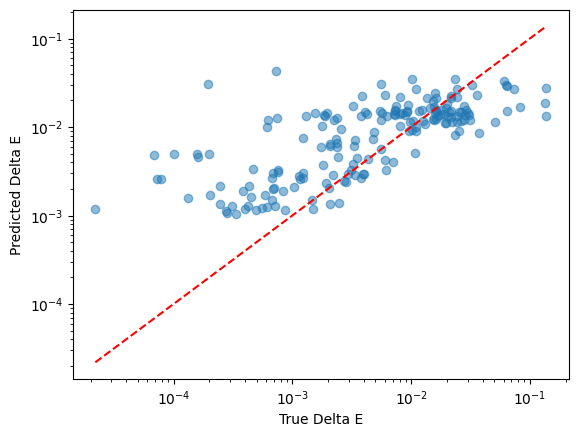

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Delta E')   
ax.set_ylabel('Predicted Delta E')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

In [37]:
xgbmodel = XGBRegressor(n_estimators=10000, 
                        random_state=42, 
                        learning_rate=0.01, 
                        early_stopping_rounds=10
                        )
xgbmodel.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgbmodel.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGB Mean Squared Error: {mse_xgb}") 
print("XGB Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred_xgb) / y_test))

XGB Mean Squared Error: 0.00040144353360886133
XGB Percentage error in prediction: 640.0972777172466


/tmp/ipykernel_2818808/3132712206.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(features, rotation=45, ha='right')
/tmp/ipykernel_2818808/3132712206.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(features, rotation=45, ha='right')


Text(0, 0.5, 'Feature Importance (RF)')

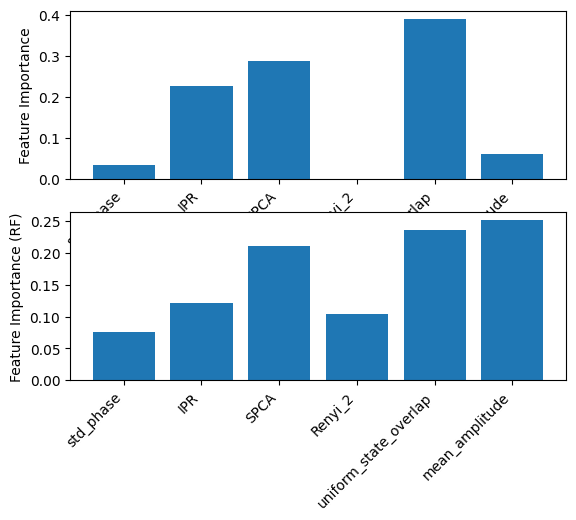

In [42]:
fig, ax = plt.subplots(2)
ax[0].bar(features, xgbmodel.feature_importances_)
ax[0].set_xticklabels(features, rotation=45, ha='right')
ax[0].set_ylabel('Feature Importance')

ax[1].bar(features, model.feature_importances_)
ax[1].set_xticklabels(features, rotation=45, ha='right')
ax[1].set_ylabel('Feature Importance (RF)')

/tmp/ipykernel_2818808/360248042.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(features, rotation=90, ha='right')
/tmp/ipykernel_2818808/360248042.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(features, rotation=90, ha='right')


[Text(0, 0, 'std_phase'),
 Text(1, 0, 'IPR'),
 Text(2, 0, 'SPCA'),
 Text(3, 0, 'Renyi_2'),
 Text(4, 0, 'uniform_state_overlap'),
 Text(5, 0, 'mean_amplitude')]

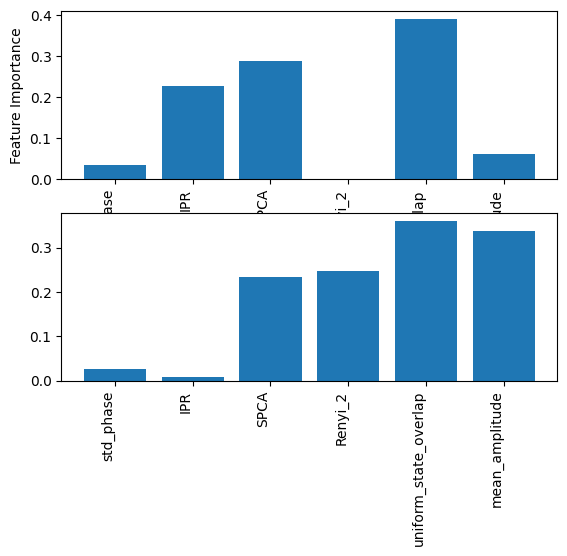

In [ ]:
fig, ax = plt.subplots(2)
scores = mutual_info_regression(X_train, y_train)

ax[0].bar(features, xgbmodel.feature_importances_)  # This does permutation importance i.e swap features and see drop in performance
ax[0].set_xticklabels(features, rotation=90, ha='right')
ax[0].set_ylabel('Feature Importance')

ax[1].bar(features, scores)
ax[1].set_xticklabels(features, rotation=90, ha='right')